In [12]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score
from ucimlrepo import fetch_ucirepo
import pandas as pd
import numpy as np

class LogisticRegressionModel(nn.Module):
    def __init__(self, input_size):
        super(LogisticRegressionModel, self).__init__()
        self.linear = nn.Linear(input_size, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        out = self.linear(x)
        out = self.sigmoid(out)
        return out

class TabularDataset:
    def __init__(self, id=17):
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.epochs = 50
        self.id = id

        # Fetch the dataset
        self.fetch_dataset()

        # Preprocess data
        self.preprocess_data()

    def fetch_dataset(self):
        self.dataset = fetch_ucirepo(id=self.id)

    def preprocess_data(self):
        # Load data and targets
        X = self.dataset.data.features
        y = self.dataset.data.targets

        # Convert non-numeric features to numeric types
        label_encoder = LabelEncoder()
        y = label_encoder.fit_transform(y)

        # Combine features and targets into a DataFrame for easy handling
        df = pd.DataFrame(data=np.column_stack((X, y)))
        
        # Drop rows with missing values
        df.dropna(inplace=True)

        # Extract features and targets after handling missing values
        self.X = df.iloc[:, :-1].values
        self.y = df.iloc[:, -1].values

    def split_data(self):
        # Split the dataset into training and testing sets
        self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(
            self.X, self.y, test_size=0.2, random_state=42
        )

    def standardize_data(self):
        # Standardize the data (optional but recommended for neural networks)
        scaler = StandardScaler()
        self.X_train = scaler.fit_transform(self.X_train)
        self.X_test = scaler.transform(self.X_test)

    def convert_to_tensors(self):
        # Convert NumPy arrays to PyTorch tensors
        self.X_train_tensor = torch.FloatTensor(self.X_train)
        self.y_train_tensor = torch.FloatTensor(self.y_train.reshape(-1, 1))
        self.X_test_tensor = torch.FloatTensor(self.X_test)
        self.y_test_tensor = torch.FloatTensor(self.y_test.reshape(-1, 1))

    def create_dataloaders(self):
        # Create PyTorch datasets and dataloaders
        self.train_dataset = TensorDataset(self.X_train_tensor, self.y_train_tensor)
        self.test_dataset = TensorDataset(self.X_test_tensor, self.y_test_tensor)
        self.train_loader = DataLoader(self.train_dataset, batch_size=32, shuffle=True)
        self.test_loader = DataLoader(self.test_dataset, batch_size=32, shuffle=False)

    def train(self, model, criterion, optimizer, train_loader):
        model.train()
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(self.device), labels.to(self.device)
            
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

    def evaluate(self, model, criterion, data_loader):
        model.eval()
        predictions = []
        targets = []

        with torch.no_grad():
            for inputs, labels in data_loader:
                inputs, labels = inputs.to(self.device), labels.to(self.device)

                outputs = model(inputs)
                predictions.extend(outputs.cpu().numpy())
                targets.extend(labels.cpu().numpy())

        predictions = np.array(predictions).flatten()
        targets = np.array(targets).flatten()
        predictions = np.round(predictions)  # Convert probabilities to binary predictions

        accuracy = accuracy_score(targets, predictions)
        return accuracy

    def run(self):
        self.split_data()
        self.standardize_data()
        self.convert_to_tensors()
        self.create_dataloaders()

        input_size = self.X_train.shape[1]
        model = LogisticRegressionModel(input_size).to(self.device)
        criterion = nn.BCELoss()
        optimizer = optim.SGD(model.parameters(), lr=0.01)

        for epoch in range(self.epochs):
            self.train(model, criterion, optimizer, self.train_loader)

            train_accuracy = self.evaluate(model, criterion, self.train_loader)
            test_accuracy = self.evaluate(model, criterion, self.test_loader)

            print(f"Epoch {epoch+1}/{self.epochs} => Train Accuracy: {train_accuracy:.4f}, Test Accuracy: {test_accuracy:.4f}")

# Example usage
tabular_model = TabularDataset(id=17)
tabular_model.run()


/packages/envs/pytorch-gpu-2.0.1/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Epoch 1/50 => Train Accuracy: 0.8769, Test Accuracy: 0.8333
Epoch 2/50 => Train Accuracy: 0.9033, Test Accuracy: 0.9386
Epoch 3/50 => Train Accuracy: 0.9275, Test Accuracy: 0.9386
Epoch 4/50 => Train Accuracy: 0.9363, Test Accuracy: 0.9649
Epoch 5/50 => Train Accuracy: 0.9407, Test Accuracy: 0.9561
Epoch 6/50 => Train Accuracy: 0.9429, Test Accuracy: 0.9561
Epoch 7/50 => Train Accuracy: 0.9451, Test Accuracy: 0.9649
Epoch 8/50 => Train Accuracy: 0.9495, Test Accuracy: 0.9649
Epoch 9/50 => Train Accuracy: 0.9495, Test Accuracy: 0.9649
Epoch 10/50 => Train Accuracy: 0.9495, Test Accuracy: 0.9649
Epoch 11/50 => Train Accuracy: 0.9516, Test Accuracy: 0.9649
Epoch 12/50 => Train Accuracy: 0.9516, Test Accuracy: 0.9737
Epoch 13/50 => Train Accuracy: 0.9516, Test Accuracy: 0.9737
Epoch 14/50 => Train Accuracy: 0.9538, Test Accuracy: 0.9737
Epoch 15/50 => Train Accuracy: 0.9538, Test Accuracy: 0.9737
Epoch 16/50 => Train Accuracy: 0.9538, Test Accuracy: 0.9737
Epoch 17/50 => Train Accuracy: 0.

/packages/envs/pytorch-gpu-2.0.1/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Epoch 1/50 => Train Accuracy: 0.8637, Test Accuracy: 0.9035
Epoch 2/50 => Train Accuracy: 0.9077, Test Accuracy: 0.9649
Epoch 3/50 => Train Accuracy: 0.9275, Test Accuracy: 0.9649
Epoch 4/50 => Train Accuracy: 0.9385, Test Accuracy: 0.9649
Epoch 5/50 => Train Accuracy: 0.9407, Test Accuracy: 0.9649
Epoch 6/50 => Train Accuracy: 0.9495, Test Accuracy: 0.9649
Epoch 7/50 => Train Accuracy: 0.9516, Test Accuracy: 0.9737
Epoch 8/50 => Train Accuracy: 0.9560, Test Accuracy: 0.9737
Epoch 9/50 => Train Accuracy: 0.9582, Test Accuracy: 0.9825
Epoch 10/50 => Train Accuracy: 0.9604, Test Accuracy: 0.9825
Epoch 11/50 => Train Accuracy: 0.9626, Test Accuracy: 0.9825
Epoch 12/50 => Train Accuracy: 0.9626, Test Accuracy: 0.9825
Epoch 13/50 => Train Accuracy: 0.9648, Test Accuracy: 0.9825
Epoch 14/50 => Train Accuracy: 0.9692, Test Accuracy: 0.9825
Epoch 15/50 => Train Accuracy: 0.9714, Test Accuracy: 0.9825
Epoch 16/50 => Train Accuracy: 0.9714, Test Accuracy: 0.9825
Epoch 17/50 => Train Accuracy: 0.

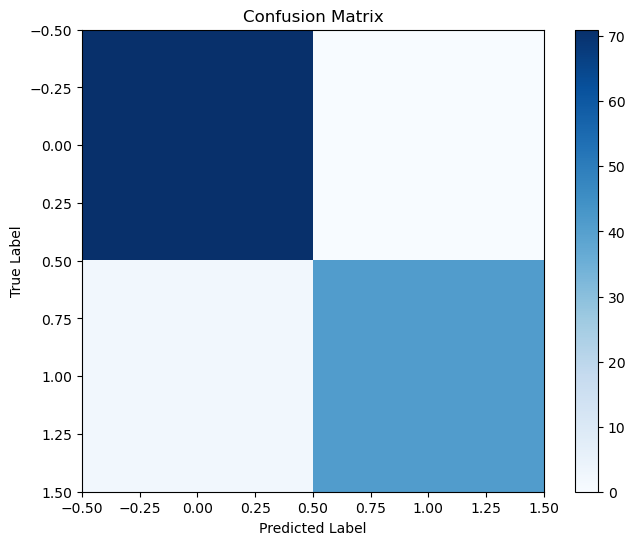

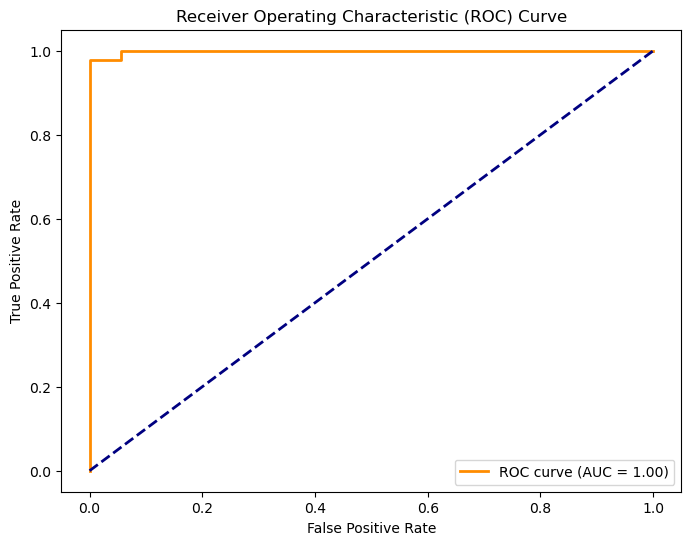

In [16]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score, confusion_matrix, roc_curve, auc
from ucimlrepo import fetch_ucirepo
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

class LogisticRegressionModel(nn.Module):
    def __init__(self, input_size):
        super(LogisticRegressionModel, self).__init__()
        self.linear = nn.Linear(input_size, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        out = self.linear(x)
        out = self.sigmoid(out)
        return out

class TabularDataset:
    def __init__(self, id=17):
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.epochs = 50
        self.id = id

        # Fetch the dataset
        self.fetch_dataset()

        # Preprocess data
        self.preprocess_data()

    def fetch_dataset(self):
        self.dataset = fetch_ucirepo(id=self.id)

    def preprocess_data(self):
        # Load data and targets
        X = self.dataset.data.features
        y = self.dataset.data.targets

        # Convert non-numeric features to numeric types
        label_encoder = LabelEncoder()
        y = label_encoder.fit_transform(y)

        # Combine features and targets into a DataFrame for easy handling
        df = pd.DataFrame(data=np.column_stack((X, y)))
        
        # Drop rows with missing values
        df.dropna(inplace=True)

        # Extract features and targets after handling missing values
        self.X = df.iloc[:, :-1].values
        self.y = df.iloc[:, -1].values

    def split_data(self):
        # Split the dataset into training and testing sets
        self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(
            self.X, self.y, test_size=0.2, random_state=42
        )

    def standardize_data(self):
        # Standardize the data (optional but recommended for neural networks)
        scaler = StandardScaler()
        self.X_train = scaler.fit_transform(self.X_train)
        self.X_test = scaler.transform(self.X_test)

    def convert_to_tensors(self):
        # Convert NumPy arrays to PyTorch tensors
        self.X_train_tensor = torch.FloatTensor(self.X_train)
        self.y_train_tensor = torch.FloatTensor(self.y_train.reshape(-1, 1))
        self.X_test_tensor = torch.FloatTensor(self.X_test)
        self.y_test_tensor = torch.FloatTensor(self.y_test.reshape(-1, 1))

    def create_dataloaders(self):
        # Create PyTorch datasets and dataloaders
        self.train_dataset = TensorDataset(self.X_train_tensor, self.y_train_tensor)
        self.test_dataset = TensorDataset(self.X_test_tensor, self.y_test_tensor)
        self.train_loader = DataLoader(self.train_dataset, batch_size=32, shuffle=True)
        self.test_loader = DataLoader(self.test_dataset, batch_size=32, shuffle=False)

    def train(self, model, criterion, optimizer, train_loader):
        model.train()
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(self.device), labels.to(self.device)
            
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

    def evaluate(self, model, criterion, data_loader):
        model.eval()
        predictions = []
        targets = []

        with torch.no_grad():
            for inputs, labels in data_loader:
                inputs, labels = inputs.to(self.device), labels.to(self.device)

                outputs = model(inputs)
                predictions.extend(outputs.cpu().numpy())
                targets.extend(labels.cpu().numpy())

        predictions = np.array(predictions).flatten()
        targets = np.array(targets).flatten()
        predictions = np.round(predictions)  # Convert probabilities to binary predictions

        accuracy = accuracy_score(targets, predictions)
        return accuracy

    def plot_confusion_matrix(self, y_true, y_pred):
        cm = confusion_matrix(y_true, y_pred)
        plt.figure(figsize=(8, 6))
        plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
        plt.title('Confusion Matrix')
        plt.colorbar()
        plt.xlabel('Predicted Label')
        plt.ylabel('True Label')
        plt.show()

    def plot_roc_curve(self, y_true, y_scores):
        fpr, tpr, _ = roc_curve(y_true, y_scores)
        roc_auc = auc(fpr, tpr)

        plt.figure(figsize=(8, 6))
        plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
        plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('Receiver Operating Characteristic (ROC) Curve')
        plt.legend(loc='lower right')
        plt.show()
        
    def run(self):
        self.split_data()
        self.standardize_data()
        self.convert_to_tensors()
        self.create_dataloaders()
    
        input_size = self.X_train.shape[1]
        model = LogisticRegressionModel(input_size).to(self.device)
        criterion = nn.BCELoss()
        optimizer = optim.SGD(model.parameters(), lr=0.01)
    
        # Training
        for epoch in range(self.epochs):
            self.train(model, criterion, optimizer, self.train_loader)
    
            train_accuracy = self.evaluate(model, criterion, self.train_loader)
            test_accuracy = self.evaluate(model, criterion, self.test_loader)
    
            print(f"Epoch {epoch+1}/{self.epochs} => Train Accuracy: {train_accuracy:.4f}, Test Accuracy: {test_accuracy:.4f}")
    
        # Evaluation
        model.eval()  # Switch to evaluation mode
        y_true = []
        y_scores = []
    
        with torch.no_grad():
            for inputs, labels in self.test_loader:
                inputs, labels = inputs.to(self.device), labels.to(self.device)
                outputs = model(inputs)
                y_true.extend(labels.cpu().numpy())
                y_scores.extend(outputs.cpu().numpy().flatten())
    
        y_true = np.array(y_true).flatten()
        y_scores = np.array(y_scores).flatten()
    
        # Confusion Matrix
        self.plot_confusion_matrix(y_true, np.round(y_scores))
    
        # ROC Curve
        self.plot_roc_curve(y_true, y_scores)


# Example usage
tabular_model = TabularDataset(id=17)
tabular_model.run()


/packages/envs/pytorch-gpu-2.0.1/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Training Set:
Accuracy: 0.978021978021978
Classification Report:
               precision    recall  f1-score   support

         0.0       0.98      0.99      0.98       286
         1.0       0.98      0.96      0.97       169

    accuracy                           0.98       455
   macro avg       0.98      0.98      0.98       455
weighted avg       0.98      0.98      0.98       455



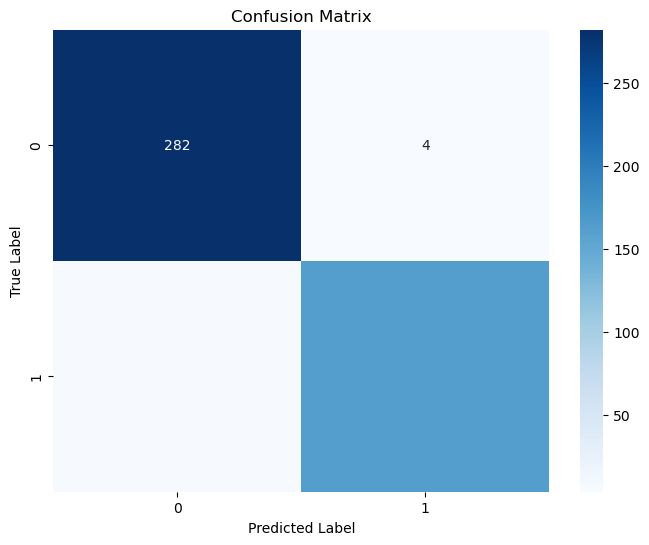

Testing Set:
Accuracy: 0.9824561403508771
Classification Report:
               precision    recall  f1-score   support

         0.0       0.99      0.99      0.99        71
         1.0       0.98      0.98      0.98        43

    accuracy                           0.98       114
   macro avg       0.98      0.98      0.98       114
weighted avg       0.98      0.98      0.98       114



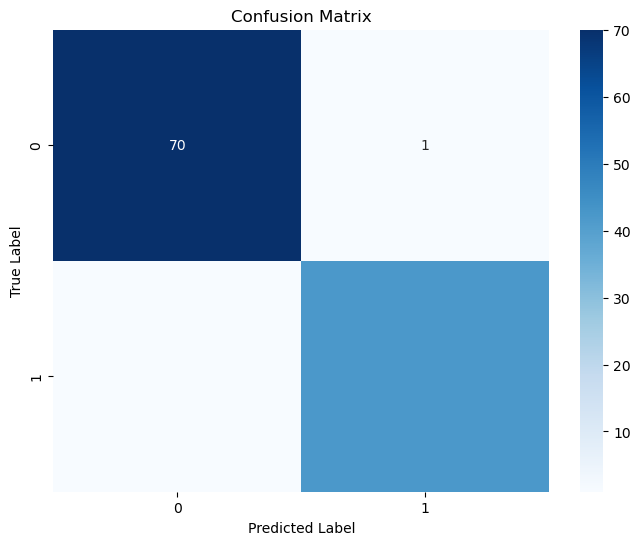

In [19]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

class LogisticRegressionModelPyTorch(nn.Module):
    def __init__(self, input_size):
        super(LogisticRegressionModelPyTorch, self).__init__()
        self.linear = nn.Linear(input_size, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        out = self.linear(x)
        out = self.sigmoid(out)
        return out

class LogisticRegressionTabular:
    def __init__(self):
        self.learning_rate = 0.01
        self.epochs = 50
        self.batch_size = 32
        self.model = None
        self.criterion = nn.BCELoss()
        self.optimizer = None

    def train(self, X_train_tensor, y_train_tensor):
        self.model.train()
        for epoch in range(self.epochs):
            for i in range(0, len(X_train_tensor), self.batch_size):
                X_batch = X_train_tensor[i:i+self.batch_size]
                y_batch = y_train_tensor[i:i+self.batch_size]

                self.optimizer.zero_grad()
                outputs = self.model(X_batch)
                loss = self.criterion(outputs, y_batch)
                loss.backward()
                self.optimizer.step()

    def evaluate(self, X_tensor, y_tensor, set_name):
        self.model.eval()
        with torch.no_grad():
            outputs = self.model(X_tensor)
            predictions = (outputs >= 0.5).float()
            accuracy = accuracy_score(y_tensor, predictions)
            report = classification_report(y_tensor, predictions)
            conf_matrix = confusion_matrix(y_tensor, predictions)
            print(f"{set_name} Set:")
            print("Accuracy:", accuracy)
            print("Classification Report:\n", report)
            self.visualize_confusion_matrix(conf_matrix)

    def visualize_confusion_matrix(self, conf_matrix):
        plt.figure(figsize=(8, 6))
        sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues")
        plt.title("Confusion Matrix")
        plt.xlabel("Predicted Label")
        plt.ylabel("True Label")
        plt.show()

    def run(self, tabular_data):
        # Assuming the input size is the number of features in your dataset
        input_size = tabular_data.X_train.shape[1]

        # Initialize the PyTorch model
        self.model = LogisticRegressionModelPyTorch(input_size)

        # Convert NumPy arrays to PyTorch tensors
        X_train_tensor = torch.FloatTensor(tabular_data.X_train)
        y_train_tensor = torch.FloatTensor(tabular_data.y_train.reshape(-1, 1))

        X_test_tensor = torch.FloatTensor(tabular_data.X_test)
        y_test_tensor = torch.FloatTensor(tabular_data.y_test.reshape(-1, 1))

        # Initialize the optimizer
        self.optimizer = optim.SGD(self.model.parameters(), lr=self.learning_rate)

        # Train the model
        self.train(X_train_tensor, y_train_tensor)

        # Evaluate on training and testing sets
        self.evaluate(X_train_tensor, y_train_tensor, "Training")
        self.evaluate(X_test_tensor, y_test_tensor, "Testing")

# Example usage
tabular_data = TabularDataset(id=17)
logreg_tabular_model = LogisticRegressionTabular()
logreg_tabular_model.run(tabular_data)


In [18]:
class TabularDataset:
    def __init__(self, id=17):
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.epochs = 50
        self.id = id
        self.fetch_dataset()

        # Preprocess data
        self.preprocess_data()

        # Split data
        self.split_data()

        # Standardize data
        self.standardize_data()

        # Convert to tensors
        self.convert_to_tensors()

        # Create dataloaders
        self.create_dataloaders()
    def fetch_dataset(self):
        self.dataset = fetch_ucirepo(id=self.id)

    def preprocess_data(self):
        # Load data and targets
        X = self.dataset.data.features
        y = self.dataset.data.targets

        # Convert non-numeric features to numeric types
        label_encoder = LabelEncoder()
        y = label_encoder.fit_transform(y)

        # Combine features and targets into a DataFrame for easy handling
        df = pd.DataFrame(data=np.column_stack((X, y)))
        
        # Drop rows with missing values
        df.dropna(inplace=True)

        # Extract features and targets after handling missing values
        self.X = df.iloc[:, :-1].values
        self.y = df.iloc[:, -1].values

    def split_data(self):
        # Split the dataset into training and testing sets
        self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(
            self.X, self.y, test_size=0.2, random_state=42
        )

    def standardize_data(self):
        # Standardize the data (optional but recommended for neural networks)
        scaler = StandardScaler()
        self.X_train = scaler.fit_transform(self.X_train)
        self.X_test = scaler.transform(self.X_test)

    def convert_to_tensors(self):
        # Convert NumPy arrays to PyTorch tensors
        self.X_train_tensor = torch.FloatTensor(self.X_train)
        self.y_train_tensor = torch.FloatTensor(self.y_train.reshape(-1, 1))
        self.X_test_tensor = torch.FloatTensor(self.X_test)
        self.y_test_tensor = torch.FloatTensor(self.y_test.reshape(-1, 1))

    def create_dataloaders(self):
        # Create PyTorch datasets and dataloaders
        self.train_dataset = TensorDataset(self.X_train_tensor, self.y_train_tensor)
        self.test_dataset = TensorDataset(self.X_test_tensor, self.y_test_tensor)
        self.train_loader = DataLoader(self.train_dataset, batch_size=32, shuffle=True)
        self.test_loader = DataLoader(self.test_dataset, batch_size=32, shuffle=False)


    def convert_to_tensors(self):
        self.X_train_tensor = torch.FloatTensor(self.X_train)
        self.y_train_tensor = torch.FloatTensor(self.y_train.reshape(-1, 1))
        self.X_test_tensor = torch.FloatTensor(self.X_test)
        self.y_test_tensor = torch.FloatTensor(self.y_test.reshape(-1, 1))

    def create_dataloaders(self):
        self.train_dataset = TensorDataset(self.X_train_tensor, self.y_train_tensor)
        self.test_dataset = TensorDataset(self.X_test_tensor, self.y_test_tensor)
        self.train_loader = DataLoader(self.train_dataset, batch_size=32, shuffle=True)
        self.test_loader = DataLoader(self.test_dataset, batch_size=32, shuffle=False)


In [20]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from ucimlrepo import fetch_ucirepo
import pandas as pd
import numpy as np

class LogisticRegressionModel(nn.Module):
    def __init__(self, input_size):
        super(LogisticRegressionModel, self).__init__()
        self.linear = nn.Linear(input_size, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        out = self.linear(x)
        out = self.sigmoid(out)
        return out

class TabularDataset:
    def __init__(self, id=17):
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.epochs = 50
        self.id = id
        self.fetch_dataset()
        self.preprocess_data()

    def fetch_dataset(self):
        self.dataset = fetch_ucirepo(id=self.id)

    def preprocess_data(self):
        X = self.dataset.data.features
        y = self.dataset.data.targets
        label_encoder = LabelEncoder()
        y = label_encoder.fit_transform(y)
        df = pd.DataFrame(data=np.column_stack((X, y)))
        df.dropna(inplace=True)
        self.X = df.iloc[:, :-1].values
        self.y = df.iloc[:, -1].values

    def split_data(self):
        self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(
            self.X, self.y, test_size=0.2, random_state=42
        )

    def standardize_data(self):
        scaler = StandardScaler()
        self.X_train = scaler.fit_transform(self.X_train)
        self.X_test = scaler.transform(self.X_test)

    def convert_to_tensors(self):
        self.X_train_tensor = torch.FloatTensor(self.X_train)
        self.y_train_tensor = torch.FloatTensor(self.y_train.reshape(-1, 1))
        self.X_test_tensor = torch.FloatTensor(self.X_test)
        self.y_test_tensor = torch.FloatTensor(self.y_test.reshape(-1, 1))

    def create_dataloaders(self):
        self.train_dataset = TensorDataset(self.X_train_tensor, self.y_train_tensor)
        self.test_dataset = TensorDataset(self.X_test_tensor, self.y_test_tensor)
        self.train_loader = DataLoader(self.train_dataset, batch_size=32, shuffle=True)
        self.test_loader = DataLoader(self.test_dataset, batch_size=32, shuffle=False)

    def logistic_regression(self):
        input_size = self.X_train.shape[1]
        model = LogisticRegressionModel(input_size).to(self.device)
        criterion = nn.BCELoss()
        optimizer = optim.SGD(model.parameters(), lr=0.01)

        for epoch in range(self.epochs):
            model.train()
            for inputs, labels in self.train_loader:
                inputs, labels = inputs.to(self.device), labels.to(self.device)
                optimizer.zero_grad()
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()

            print(f'Epoch [{epoch + 1}/{self.epochs}], Loss: {loss.item():.4f}')

        model.eval()
        with torch.no_grad():
            correct = 0
            total = 0
            for inputs, labels in self.test_loader:
                inputs, labels = inputs.to(self.device), labels.to(self.device)
                outputs = model(inputs)
                predicted = (outputs > 0.5).float()
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        accuracy = correct / total
        print(f'Test Accuracy: {accuracy * 100:.2f}%')

# Example usage
if __name__ == "__main__":
    tabular_data = TabularDataset(id=17)
    tabular_data.split_data()
    tabular_data.standardize_data()
    tabular_data.convert_to_tensors()
    tabular_data.create_dataloaders()
    tabular_data.logistic_regression()


/packages/envs/pytorch-gpu-2.0.1/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Epoch [1/50], Loss: 0.4892
Epoch [2/50], Loss: 0.3572
Epoch [3/50], Loss: 0.3010
Epoch [4/50], Loss: 0.2873
Epoch [5/50], Loss: 0.1441
Epoch [6/50], Loss: 0.1030
Epoch [7/50], Loss: 0.1660
Epoch [8/50], Loss: 0.3131
Epoch [9/50], Loss: 0.1383
Epoch [10/50], Loss: 0.2118
Epoch [11/50], Loss: 0.2626
Epoch [12/50], Loss: 0.2460
Epoch [13/50], Loss: 0.3093
Epoch [14/50], Loss: 0.2854
Epoch [15/50], Loss: 0.1364
Epoch [16/50], Loss: 0.1760
Epoch [17/50], Loss: 0.1188
Epoch [18/50], Loss: 0.1223
Epoch [19/50], Loss: 0.1957
Epoch [20/50], Loss: 0.2129
Epoch [21/50], Loss: 0.0633
Epoch [22/50], Loss: 0.1603
Epoch [23/50], Loss: 0.2111
Epoch [24/50], Loss: 0.1183
Epoch [25/50], Loss: 0.1660
Epoch [26/50], Loss: 0.3010
Epoch [27/50], Loss: 0.1128
Epoch [28/50], Loss: 0.1254
Epoch [29/50], Loss: 0.0975
Epoch [30/50], Loss: 0.0401
Epoch [31/50], Loss: 0.0941
Epoch [32/50], Loss: 0.0967
Epoch [33/50], Loss: 0.0290
Epoch [34/50], Loss: 0.1222
Epoch [35/50], Loss: 0.0806
Epoch [36/50], Loss: 0.3159
E

In [22]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from ucimlrepo import fetch_ucirepo
import pandas as pd
import numpy as np
import itertools

class LogisticRegressionModel(nn.Module):
    def __init__(self, input_size, learning_rate, weight_decay):
        super(LogisticRegressionModel, self).__init__()
        self.linear = nn.Linear(input_size, 1)
        self.sigmoid = nn.Sigmoid()
        self.learning_rate = learning_rate
        self.weight_decay = weight_decay

    def forward(self, x):
        out = self.linear(x)
        out = self.sigmoid(out)
        return out

class TabularDataset:
    def __init__(self, id=17):
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.epochs = 50
        self.id = id
        self.fetch_dataset()
        self.preprocess_data()

    def fetch_dataset(self):
        self.dataset = fetch_ucirepo(id=self.id)

    def preprocess_data(self):
        X = self.dataset.data.features
        y = self.dataset.data.targets
        label_encoder = LabelEncoder()
        y = label_encoder.fit_transform(y)
        df = pd.DataFrame(data=np.column_stack((X, y)))
        df.dropna(inplace=True)
        self.X = df.iloc[:, :-1].values
        self.y = df.iloc[:, -1].values

    def split_data(self):
        self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(
            self.X, self.y, test_size=0.2, random_state=42
        )

    def standardize_data(self):
        scaler = StandardScaler()
        self.X_train = scaler.fit_transform(self.X_train)
        self.X_test = scaler.transform(self.X_test)

    def convert_to_tensors(self):
        self.X_train_tensor = torch.FloatTensor(self.X_train)
        self.y_train_tensor = torch.FloatTensor(self.y_train.reshape(-1, 1))
        self.X_test_tensor = torch.FloatTensor(self.X_test)
        self.y_test_tensor = torch.FloatTensor(self.y_test.reshape(-1, 1))

    def create_dataloaders(self):
        self.train_dataset = TensorDataset(self.X_train_tensor, self.y_train_tensor)
        self.test_dataset = TensorDataset(self.X_test_tensor, self.y_test_tensor)
        self.train_loader = DataLoader(self.train_dataset, batch_size=32, shuffle=True)
        self.test_loader = DataLoader(self.test_dataset, batch_size=32, shuffle=False)

class GridSearch:
    def __init__(self, model_class, hyperparameters, id=17):
        self.model_class = model_class
        self.hyperparameters = hyperparameters
        self.id = id
        self.results = []

    def run_search(self):
        param_combinations = list(itertools.product(*self.hyperparameters.values()))

        for params in param_combinations:
            print(f"Testing hyperparameters: {dict(zip(self.hyperparameters.keys(), params))}")
            tabular_data = TabularDataset(id=self.id)
            tabular_data.split_data()
            tabular_data.standardize_data()
            tabular_data.convert_to_tensors()
            tabular_data.create_dataloaders()

            model = self.model_class(tabular_data.X_train.shape[1], *params).to(tabular_data.device)
            criterion = nn.BCELoss()
            optimizer = optim.SGD(model.parameters(), lr=params[0], weight_decay=params[1])

            for epoch in range(tabular_data.epochs):
                model.train()
                for inputs, labels in tabular_data.train_loader:
                    inputs, labels = inputs.to(tabular_data.device), labels.to(tabular_data.device)
                    optimizer.zero_grad()
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)
                    loss.backward()
                    optimizer.step()

            model.eval()
            with torch.no_grad():
                correct = 0
                total = 0
                for inputs, labels in tabular_data.test_loader:
                    inputs, labels = inputs.to(tabular_data.device), labels.to(tabular_data.device)
                    outputs = model(inputs)
                    predicted = (outputs > 0.5).float()
                    total += labels.size(0)
                    correct += (predicted == labels).sum().item()

            accuracy = correct / total
            print(f'Test Accuracy: {accuracy * 100:.2f}%')
            self.results.append({
                'params': dict(zip(self.hyperparameters.keys(), params)),
                'accuracy': accuracy
            })

if __name__ == "__main__":
    hyperparameters = {
        'learning_rate': [0.001, 0.01, 0.1],
        'weight_decay': [0, 1e-4, 1e-3]
    }

    grid_search = GridSearch(LogisticRegressionModel, hyperparameters, id=17)
    grid_search.run_search()

    # Print results
    print("\nGrid Search Results:")
    for result in grid_search.results:
        print(f"Hyperparameters: {result['params']}, Accuracy: {result['accuracy'] * 100:.2f}%")


Testing hyperparameters: {'learning_rate': 0.001, 'weight_decay': 0}


/packages/envs/pytorch-gpu-2.0.1/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Test Accuracy: 96.49%
Testing hyperparameters: {'learning_rate': 0.001, 'weight_decay': 0.0001}


/packages/envs/pytorch-gpu-2.0.1/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Test Accuracy: 97.37%
Testing hyperparameters: {'learning_rate': 0.001, 'weight_decay': 0.001}


/packages/envs/pytorch-gpu-2.0.1/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Test Accuracy: 96.49%
Testing hyperparameters: {'learning_rate': 0.01, 'weight_decay': 0}


/packages/envs/pytorch-gpu-2.0.1/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Test Accuracy: 96.49%
Testing hyperparameters: {'learning_rate': 0.01, 'weight_decay': 0.0001}


/packages/envs/pytorch-gpu-2.0.1/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Test Accuracy: 97.37%
Testing hyperparameters: {'learning_rate': 0.01, 'weight_decay': 0.001}


/packages/envs/pytorch-gpu-2.0.1/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Test Accuracy: 99.12%
Testing hyperparameters: {'learning_rate': 0.1, 'weight_decay': 0}


/packages/envs/pytorch-gpu-2.0.1/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Test Accuracy: 98.25%
Testing hyperparameters: {'learning_rate': 0.1, 'weight_decay': 0.0001}


/packages/envs/pytorch-gpu-2.0.1/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Test Accuracy: 99.12%
Testing hyperparameters: {'learning_rate': 0.1, 'weight_decay': 0.001}


/packages/envs/pytorch-gpu-2.0.1/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Test Accuracy: 98.25%

Grid Search Results:
Hyperparameters: {'learning_rate': 0.001, 'weight_decay': 0}, Accuracy: 96.49%
Hyperparameters: {'learning_rate': 0.001, 'weight_decay': 0.0001}, Accuracy: 97.37%
Hyperparameters: {'learning_rate': 0.001, 'weight_decay': 0.001}, Accuracy: 96.49%
Hyperparameters: {'learning_rate': 0.01, 'weight_decay': 0}, Accuracy: 96.49%
Hyperparameters: {'learning_rate': 0.01, 'weight_decay': 0.0001}, Accuracy: 97.37%
Hyperparameters: {'learning_rate': 0.01, 'weight_decay': 0.001}, Accuracy: 99.12%
Hyperparameters: {'learning_rate': 0.1, 'weight_decay': 0}, Accuracy: 98.25%
Hyperparameters: {'learning_rate': 0.1, 'weight_decay': 0.0001}, Accuracy: 99.12%
Hyperparameters: {'learning_rate': 0.1, 'weight_decay': 0.001}, Accuracy: 98.25%


In [27]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import StandardScaler, LabelEncoder
from ucimlrepo import fetch_ucirepo
import pandas as pd
import numpy as np
import itertools

class LogisticRegressionModel(nn.Module):
    def __init__(self, input_size, learning_rate, weight_decay):
        super(LogisticRegressionModel, self).__init__()
        self.linear = nn.Linear(input_size, 1)
        self.sigmoid = nn.Sigmoid()
        self.learning_rate = learning_rate
        self.weight_decay = weight_decay

    def forward(self, x):
        out = self.linear(x)
        out = self.sigmoid(out)
        return out

class TabularDataset:
    def __init__(self, id=17):
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.epochs = 50
        self.id = id
        self.fetch_dataset()
        self.preprocess_data()

    def fetch_dataset(self):
        self.dataset = fetch_ucirepo(id=self.id)

    def preprocess_data(self):
        X = self.dataset.data.features
        y = self.dataset.data.targets
        label_encoder = LabelEncoder()
        y = label_encoder.fit_transform(y)
        df = pd.DataFrame(data=np.column_stack((X, y)))
        df.dropna(inplace=True)
        self.X = df.iloc[:, :-1].values
        self.y = df.iloc[:, -1].values

    def split_data(self):
        self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(
            self.X, self.y, test_size=0.2, random_state=42
        )

    def standardize_data(self):
        scaler = StandardScaler()
        self.X_train = scaler.fit_transform(self.X_train)
        self.X_test = scaler.transform(self.X_test)

    def convert_to_tensors(self):
        self.X_train_tensor = torch.FloatTensor(self.X_train)
        self.y_train_tensor = torch.FloatTensor(self.y_train.reshape(-1, 1))
        self.X_test_tensor = torch.FloatTensor(self.X_test)
        self.y_test_tensor = torch.FloatTensor(self.y_test.reshape(-1, 1))

    def create_dataloaders(self, train_indices, test_indices):
        train_sampler = torch.utils.data.sampler.SubsetRandomSampler(train_indices)
        test_sampler = torch.utils.data.sampler.SubsetRandomSampler(test_indices)

        self.train_loader = DataLoader(self.train_dataset, batch_size=32, sampler=train_sampler)
        self.test_loader = DataLoader(self.test_dataset, batch_size=32, sampler=test_sampler)

    def cross_validation(self, model_class, hyperparameters, num_folds=5):
        skf = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

        results = []

        for train_indices, test_indices in skf.split(self.X, self.y):
            tabular_data = TabularDataset(id=self.id)
            tabular_data.standardize_data()
            tabular_data.X_train, tabular_data.X_test = tabular_data.X[train_indices], tabular_data.X[test_indices]
            tabular_data.y_train, tabular_data.y_test = tabular_data.y[train_indices], tabular_data.y[test_indices]
            tabular_data.convert_to_tensors()
            tabular_data.create_dataloaders(train_indices, test_indices)

            grid_search = GridSearch(model_class, hyperparameters)
            grid_search.run_search()

            best_result = max(grid_search.results, key=lambda x: x['accuracy'])
            results.append(best_result)

        return results

class GridSearch:
    def __init__(self, model_class, hyperparameters):
        self.model_class = model_class
        self.hyperparameters = hyperparameters
        self.results = []

    def run_search(self):
        param_combinations = list(itertools.product(*self.hyperparameters.values()))

        for params in param_combinations:
            tabular_data = TabularDataset(id=17)
            tabular_data.standardize_data()
            tabular_data.convert_to_tensors()
            tabular_data.create_dataloaders()

            model = self.model_class(tabular_data.X_train.shape[1], *params).to(tabular_data.device)
            criterion = nn.BCELoss()
            optimizer = optim.SGD(model.parameters(), lr=params[0], weight_decay=params[1])

            for epoch in range(tabular_data.epochs):
                model.train()
                for inputs, labels in tabular_data.train_loader:
                    inputs, labels = inputs.to(tabular_data.device), labels.to(tabular_data.device)
                    optimizer.zero_grad()
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)
                    loss.backward()
                    optimizer.step()

            model.eval()
            with torch.no_grad():
                correct = 0
                total = 0
                for inputs, labels in tabular_data.test_loader:
                    inputs, labels = inputs.to(tabular_data.device), labels.to(tabular_data.device)
                    outputs = model(inputs)
                    predicted = (outputs > 0.5).float()
                    total += labels.size(0)
                    correct += (predicted == labels).sum().item()

            accuracy = correct / total
            self.results.append({
                'params': dict(zip(self.hyperparameters.keys(), params)),
                'accuracy': accuracy
            })

if __name__ == "__main__":
    hyperparameters = {
        'learning_rate': [0.001, 0.01, 0.1],
        'weight_decay': [0, 1e-4, 1e-3]
    }

    results = TabularDataset().cross_validation(LogisticRegressionModel, hyperparameters, num_folds=5)

    # Print cross-validation results
    print("\nCross-Validation Results:")
    for result in results:
        print(f"Hyperparameters: {result['params']}, Accuracy: {result['accuracy'] * 100:.2f}%")


/packages/envs/pytorch-gpu-2.0.1/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/packages/envs/pytorch-gpu-2.0.1/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


AttributeError: 'TabularDataset' object has no attribute 'X_train'

In [28]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler, LabelEncoder
from ucimlrepo import fetch_ucirepo
import pandas as pd
import numpy as np
import itertools

class LogisticRegressionModel(nn.Module):
    def __init__(self, input_size, learning_rate, weight_decay):
        super(LogisticRegressionModel, self).__init__()
        self.linear = nn.Linear(input_size, 1)
        self.sigmoid = nn.Sigmoid()
        self.learning_rate = learning_rate
        self.weight_decay = weight_decay

    def forward(self, x):
        out = self.linear(x)
        out = self.sigmoid(out)
        return out

class TabularDataset:
    def __init__(self, id=17):
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.epochs = 50
        self.id = id
        self.fetch_dataset()
        self.preprocess_data()
        self.split_data()
        self.standardize_data()
        self.convert_to_tensors()
        self.create_dataloaders()

    def fetch_dataset(self):
        self.dataset = fetch_ucirepo(id=self.id)

    def preprocess_data(self):
        X = self.dataset.data.features
        y = self.dataset.data.targets
        label_encoder = LabelEncoder()
        y = label_encoder.fit_transform(y)
        df = pd.DataFrame(data=np.column_stack((X, y)))
        df.dropna(inplace=True)
        self.X = df.iloc[:, :-1].values
        self.y = df.iloc[:, -1].values

    def split_data(self):
        self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(
            self.X, self.y, test_size=0.2, random_state=42
        )

    def standardize_data(self):
        scaler = StandardScaler()
        self.X_train = scaler.fit_transform(self.X_train)
        self.X_test = scaler.transform(self.X_test)

    def convert_to_tensors(self):
        self.X_train_tensor = torch.FloatTensor(self.X_train)
        self.y_train_tensor = torch.FloatTensor(self.y_train.reshape(-1, 1))
        self.X_test_tensor = torch.FloatTensor(self.X_test)
        self.y_test_tensor = torch.FloatTensor(self.y_test.reshape(-1, 1))

    def create_dataloaders(self):
        self.train_dataset = TensorDataset(self.X_train_tensor, self.y_train_tensor)
        self.test_dataset = TensorDataset(self.X_test_tensor, self.y_test_tensor)
        self.train_loader = DataLoader(self.train_dataset, batch_size=32, shuffle=True)
        self.test_loader = DataLoader(self.test_dataset, batch_size=32, shuffle=False)

    def cross_validation(self, model_class, hyperparameters, num_folds=5):
        skf = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

        results = []

        for train_indices, test_indices in skf.split(self.X, self.y):
            tabular_data = TabularDataset(id=self.id)
            tabular_data.X_train, tabular_data.X_test = tabular_data.X[train_indices], tabular_data.X[test_indices]
            tabular_data.y_train, tabular_data.y_test = tabular_data.y[train_indices], tabular_data.y[test_indices]
            tabular_data.standardize_data()
            tabular_data.convert_to_tensors()
            tabular_data.create_dataloaders()

            grid_search = GridSearch(model_class, hyperparameters)
            grid_search.run_search()

            best_result = max(grid_search.results, key=lambda x: x['accuracy'])
            results.append(best_result)

        return results

class GridSearch:
    def __init__(self, model_class, hyperparameters):
        self.model_class = model_class
        self.hyperparameters = hyperparameters
        self.results = []

    def run_search(self):
        param_combinations = list(itertools.product(*self.hyperparameters.values()))

        for params in param_combinations:
            tabular_data = TabularDataset(id=17)
            tabular_data.standardize_data()
            tabular_data.convert_to_tensors()
            tabular_data.create_dataloaders()

            model = self.model_class(tabular_data.X_train.shape[1], *params).to(tabular_data.device)
            criterion = nn.BCELoss()
            optimizer = optim.SGD(model.parameters(), lr=params[0], weight_decay=params[1])

            for epoch in range(tabular_data.epochs):
                model.train()
                for inputs, labels in tabular_data.train_loader:
                    inputs, labels = inputs.to(tabular_data.device), labels.to(tabular_data.device)
                    optimizer.zero_grad()
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)
                    loss.backward()
                    optimizer.step()

            model.eval()
            with torch.no_grad():
                correct = 0
                total = 0
                for inputs, labels in tabular_data.test_loader:
                    inputs, labels = inputs.to(tabular_data.device), labels.to(tabular_data.device)
                    outputs = model(inputs)
                    predicted = (outputs > 0.5).float()
                    total += labels.size(0)
                    correct += (predicted == labels).sum().item()

            accuracy = correct / total
            self.results.append({
                'params': dict(zip(self.hyperparameters.keys(), params)),
                'accuracy': accuracy
            })

if __name__ == "__main__":
    hyperparameters = {
        'learning_rate': [0.001, 0.01, 0.1],
        'weight_decay': [0, 1e-4, 1e-3]
    }

    results = TabularDataset().cross_validation(LogisticRegressionModel, hyperparameters, num_folds=5)

    # Print cross-validation results
    print("\nCross-Validation Results:")
    for result in results:
        print(f"Hyperparameters: {result['params']}, Accuracy: {result['accuracy'] * 100:.2f}%")


/packages/envs/pytorch-gpu-2.0.1/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/packages/envs/pytorch-gpu-2.0.1/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/packages/envs/pytorch-gpu-2.0.1/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/packages/envs/pytorch-gpu-2.0.1/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:114: DataConversionWarning: A column-vecto


Cross-Validation Results:
Hyperparameters: {'learning_rate': 0.1, 'weight_decay': 0.0001}, Accuracy: 99.12%
Hyperparameters: {'learning_rate': 0.01, 'weight_decay': 0.001}, Accuracy: 99.12%
Hyperparameters: {'learning_rate': 0.001, 'weight_decay': 0.001}, Accuracy: 98.25%
Hyperparameters: {'learning_rate': 0.1, 'weight_decay': 0.0001}, Accuracy: 99.12%
Hyperparameters: {'learning_rate': 0.01, 'weight_decay': 0}, Accuracy: 99.12%


In [33]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler, LabelEncoder
from ucimlrepo import fetch_ucirepo
import pandas as pd
import numpy as np
import itertools

class LogisticRegressionModel(nn.Module):
    def __init__(self, input_size, learning_rate, weight_decay):
        super(LogisticRegressionModel, self).__init__()
        self.linear = nn.Linear(input_size, 1)
        self.sigmoid = nn.Sigmoid()
        self.learning_rate = learning_rate
        self.weight_decay = weight_decay

    def forward(self, x):
        out = self.linear(x)
        out = self.sigmoid(out)
        return out

class TabularDataset:
    def __init__(self, id=17):
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.epochs = 50
        self.id = id
        self.fetch_dataset()
        self.preprocess_data()
        self.split_data()
        self.standardize_data()
        self.convert_to_tensors()
        self.create_dataloaders()

    def fetch_dataset(self):
        self.dataset = fetch_ucirepo(id=self.id)

    def preprocess_data(self):
        X = self.dataset.data.features
        y = self.dataset.data.targets
        label_encoder = LabelEncoder()
        y = label_encoder.fit_transform(y)
        df = pd.DataFrame(data=np.column_stack((X, y)))
        df.dropna(inplace=True)
        self.X = df.iloc[:, :-1].values
        self.y = df.iloc[:, -1].values

    def split_data(self):
        self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(
            self.X, self.y, test_size=0.2, random_state=42
        )

    def standardize_data(self):
        scaler = StandardScaler()
        self.X_train = scaler.fit_transform(self.X_train)
        self.X_test = scaler.transform(self.X_test)

    def convert_to_tensors(self):
        self.X_train_tensor = torch.FloatTensor(self.X_train)
        self.y_train_tensor = torch.FloatTensor(self.y_train.reshape(-1, 1))
        self.X_test_tensor = torch.FloatTensor(self.X_test)
        self.y_test_tensor = torch.FloatTensor(self.y_test.reshape(-1, 1))

    def create_dataloaders(self):
        self.train_dataset = TensorDataset(self.X_train_tensor, self.y_train_tensor)
        self.test_dataset = TensorDataset(self.X_test_tensor, self.y_test_tensor)
        self.train_loader = DataLoader(self.train_dataset, batch_size=32, shuffle=True)
        self.test_loader = DataLoader(self.test_dataset, batch_size=32, shuffle=False)

    def cross_validation(self, model_class, hyperparameters, num_folds=5):
        skf = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

        results = []

        for train_indices, test_indices in skf.split(self.X, self.y):
            tabular_data = TabularDataset(id=self.id)
            tabular_data.X_train, tabular_data.X_test = tabular_data.X[train_indices], tabular_data.X[test_indices]
            tabular_data.y_train, tabular_data.y_test = tabular_data.y[train_indices], tabular_data.y[test_indices]
            tabular_data.standardize_data()
            tabular_data.convert_to_tensors()
            tabular_data.create_dataloaders()

            grid_search = GridSearch(model_class, hyperparameters)
            grid_search.run_search(tabular_data)

            best_result = max(grid_search.results, key=lambda x: x['val_accuracy'])
            results.append(best_result)

        return results

class GridSearch:
    def __init__(self, model_class, hyperparameters):
        self.model_class = model_class
        self.hyperparameters = hyperparameters
        self.results = []

    def run_search(self, tabular_data):
        param_combinations = list(itertools.product(*self.hyperparameters.values()))
    
        for params in param_combinations:
            model = self.model_class(tabular_data.X_train.shape[1], *params).to(tabular_data.device)
            criterion = nn.BCELoss()
            optimizer = optim.SGD(model.parameters(), lr=params[0], weight_decay=params[1])
    
            for epoch in range(tabular_data.epochs):
                model.train()
                for inputs, labels in tabular_data.train_loader:
                    inputs, labels = inputs.to(tabular_data.device), labels.to(tabular_data.device)
                    optimizer.zero_grad()
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)
                    loss.backward()
                    optimizer.step()
    
            model.eval()
            with torch.no_grad():
                correct_test = 0
                total_test = 0
                for inputs, labels in tabular_data.test_loader:
                    inputs, labels = inputs.to(tabular_data.device), labels.to(tabular_data.device)
                    outputs = model(inputs)
                    predicted = (outputs > 0.5).float()
                    total_test += labels.size(0)
                    correct_test += (predicted == labels).sum().item()
    
                test_accuracy = correct_test / total_test
    
                correct_val = 0
                total_val = 0
                for inputs, labels in tabular_data.val_loader:
                    inputs, labels = inputs.to(tabular_data.device), labels.to(tabular_data.device)
                    outputs = model(inputs)
                    predicted = (outputs > 0.5).float()
                    total_val += labels.size(0)
                    correct_val += (predicted == labels).sum().item()
    
                val_accuracy = correct_val / total_val
    
                self.results.append({
                    'params': dict(zip(self.hyperparameters.keys(), params)),
                    'test_accuracy': test_accuracy,
                    'val_accuracy': val_accuracy
                })

if __name__ == "__main__":
    hyperparameters = {
        'learning_rate': [0.001, 0.01, 0.1],
        'weight_decay': [0, 1e-4, 1e-3]
    }

    results = TabularDataset().cross_validation(LogisticRegressionModel, hyperparameters, num_folds=5)

    # Print cross-validation results
    print("\nCross-Validation Results:")
    for result in results:
        print(f"Hyperparameters: {result['params']}, Test Accuracy: {result['test_accuracy'] * 100:.2f}%, Val Accuracy: {result['val_accuracy'] * 100:.2f}%")


/packages/envs/pytorch-gpu-2.0.1/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/packages/envs/pytorch-gpu-2.0.1/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


AttributeError: 'TabularDataset' object has no attribute 'val_loader'

In [34]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler, LabelEncoder
from ucimlrepo import fetch_ucirepo
import pandas as pd
import numpy as np
import itertools

class LogisticRegressionModel(nn.Module):
    def __init__(self, input_size, learning_rate, weight_decay):
        super(LogisticRegressionModel, self).__init__()
        self.linear = nn.Linear(input_size, 1)
        self.sigmoid = nn.Sigmoid()
        self.learning_rate = learning_rate
        self.weight_decay = weight_decay

    def forward(self, x):
        out = self.linear(x)
        out = self.sigmoid(out)
        return out

class TabularDataset:
    def __init__(self, id=17):
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.epochs = 50
        self.id = id
        self.fetch_dataset()
        self.preprocess_data()
        self.split_data()
        self.standardize_data()
        self.convert_to_tensors()
        self.create_dataloaders()

    def fetch_dataset(self):
        self.dataset = fetch_ucirepo(id=self.id)

    def preprocess_data(self):
        X = self.dataset.data.features
        y = self.dataset.data.targets
        label_encoder = LabelEncoder()
        y = label_encoder.fit_transform(y)
        df = pd.DataFrame(data=np.column_stack((X, y)))
        df.dropna(inplace=True)
        self.X = df.iloc[:, :-1].values
        self.y = df.iloc[:, -1].values

    def split_data(self):
        self.X_train, self.X_temp, self.y_train, self.y_temp = train_test_split(
            self.X, self.y, test_size=0.4, random_state=42
        )
        self.X_val, self.X_test, self.y_val, self.y_test = train_test_split(
            self.X_temp, self.y_temp, test_size=0.5, random_state=42
        )

    def standardize_data(self):
        scaler = StandardScaler()
        self.X_train = scaler.fit_transform(self.X_train)
        self.X_val = scaler.transform(self.X_val)
        self.X_test = scaler.transform(self.X_test)

    def convert_to_tensors(self):
        self.X_train_tensor = torch.FloatTensor(self.X_train)
        self.y_train_tensor = torch.FloatTensor(self.y_train.reshape(-1, 1))
        self.X_val_tensor = torch.FloatTensor(self.X_val)
        self.y_val_tensor = torch.FloatTensor(self.y_val.reshape(-1, 1))
        self.X_test_tensor = torch.FloatTensor(self.X_test)
        self.y_test_tensor = torch.FloatTensor(self.y_test.reshape(-1, 1))

    def create_dataloaders(self):
        self.train_dataset = TensorDataset(self.X_train_tensor, self.y_train_tensor)
        self.val_dataset = TensorDataset(self.X_val_tensor, self.y_val_tensor)
        self.test_dataset = TensorDataset(self.X_test_tensor, self.y_test_tensor)

        self.train_loader = DataLoader(self.train_dataset, batch_size=32, shuffle=True)
        self.val_loader = DataLoader(self.val_dataset, batch_size=32, shuffle=False)
        self.test_loader = DataLoader(self.test_dataset, batch_size=32, shuffle=False)

    def cross_validation(self, model_class, hyperparameters, num_folds=5):
        skf = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

        results = []

        for train_indices, test_indices in skf.split(self.X_train, self.y_train):
            tabular_data = TabularDataset(id=self.id)
            tabular_data.X_train, tabular_data.X_val = tabular_data.X_train[train_indices], tabular_data.X_train[test_indices]
            tabular_data.y_train, tabular_data.y_val = tabular_data.y_train[train_indices], tabular_data.y_train[test_indices]
            tabular_data.standardize_data()
            tabular_data.convert_to_tensors()
            tabular_data.create_dataloaders()

            grid_search = GridSearch(model_class, hyperparameters)
            grid_search.run_search(tabular_data)

            best_result = max(grid_search.results, key=lambda x: x['val_accuracy'])
            results.append(best_result)

        return results

class GridSearch:
    def __init__(self, model_class, hyperparameters):
        self.model_class = model_class
        self.hyperparameters = hyperparameters
        self.results = []

    def run_search(self, tabular_data):
        param_combinations = list(itertools.product(*self.hyperparameters.values()))

        for params in param_combinations:
            model = self.model_class(tabular_data.X_train.shape[1], *params).to(tabular_data.device)
            criterion = nn.BCELoss()
            optimizer = optim.SGD(model.parameters(), lr=params[0], weight_decay=params[1])

            for epoch in range(tabular_data.epochs):
                model.train()
                for inputs, labels in tabular_data.train_loader:
                    inputs, labels = inputs.to(tabular_data.device), labels.to(tabular_data.device)
                    optimizer.zero_grad()
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)
                    loss.backward()
                    optimizer.step()

            model.eval()
            with torch.no_grad():
                correct_test = 0
                total_test = 0
                for inputs, labels in tabular_data.test_loader:
                    inputs, labels = inputs.to(tabular_data.device), labels.to(tabular_data.device)
                    outputs = model(inputs)
                    predicted = (outputs > 0.5).float()
                    total_test += labels.size(0)
                    correct_test += (predicted == labels).sum().item()

                test_accuracy = correct_test / total_test

                correct_val = 0
                total_val = 0
                for inputs, labels in tabular_data.val_loader:
                    inputs, labels = inputs.to(tabular_data.device), labels.to(tabular_data.device)
                    outputs = model(inputs)
                    predicted = (outputs > 0.5).float()
                    total_val += labels.size(0)
                    correct_val += (predicted == labels).sum().item()

                val_accuracy = correct_val / total_val

                self.results.append({
                    'params': dict(zip(self.hyperparameters.keys(), params)),
                    'test_accuracy': test_accuracy,
                    'val_accuracy': val_accuracy
                })

if __name__ == "__main__":
    hyperparameters = {
        'learning_rate': [0.001, 0.01, 0.1],
        'weight_decay': [0, 1e-4, 1e-3]
    }

    results = TabularDataset().cross_validation(LogisticRegressionModel, hyperparameters, num_folds=5)

    # Print cross-validation results
    print("\nCross-Validation Results:")
    for result in results:
        print(f"Hyperparameters: {result['params']}, Test Accuracy: {result['test_accuracy'] * 100:.2f}%, Val Accuracy: {result['val_accuracy'] * 100:.2f}%")


/packages/envs/pytorch-gpu-2.0.1/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/packages/envs/pytorch-gpu-2.0.1/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/packages/envs/pytorch-gpu-2.0.1/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/packages/envs/pytorch-gpu-2.0.1/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:114: DataConversionWarning: A column-vecto


Cross-Validation Results:
Hyperparameters: {'learning_rate': 0.1, 'weight_decay': 0}, Test Accuracy: 98.25%, Val Accuracy: 100.00%
Hyperparameters: {'learning_rate': 0.01, 'weight_decay': 0.001}, Test Accuracy: 99.12%, Val Accuracy: 97.06%
Hyperparameters: {'learning_rate': 0.01, 'weight_decay': 0.0001}, Test Accuracy: 99.12%, Val Accuracy: 97.06%
Hyperparameters: {'learning_rate': 0.1, 'weight_decay': 0}, Test Accuracy: 99.12%, Val Accuracy: 94.12%
Hyperparameters: {'learning_rate': 0.01, 'weight_decay': 0.0001}, Test Accuracy: 99.12%, Val Accuracy: 100.00%


/packages/envs/pytorch-gpu-2.0.1/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Test Accuracy: 99.12%


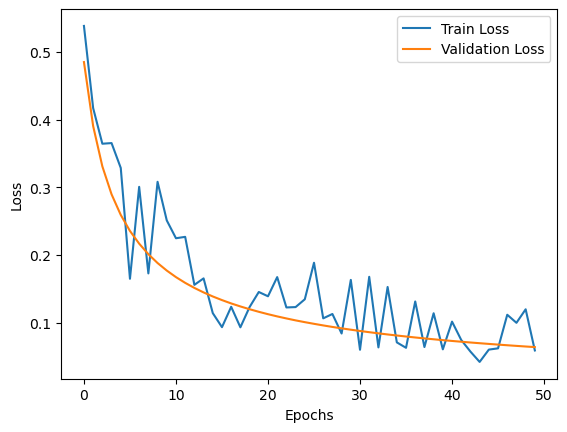

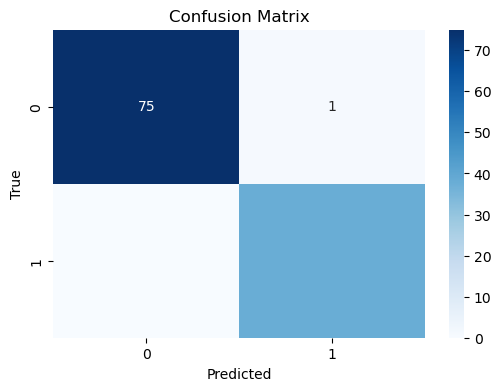

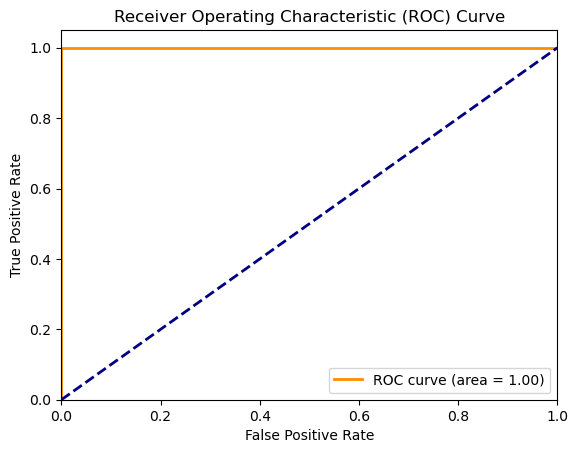

In [56]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import confusion_matrix, roc_curve, auc
from sklearn.preprocessing import StandardScaler, LabelEncoder
from ucimlrepo import fetch_ucirepo
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score

class LogisticRegressionModel(nn.Module):
    def __init__(self, input_size, learning_rate, weight_decay):
        super(LogisticRegressionModel, self).__init__()
        self.linear = nn.Linear(input_size, 1)
        self.sigmoid = nn.Sigmoid()
        self.learning_rate = learning_rate
        self.weight_decay = weight_decay

    def forward(self, x):
        out = self.linear(x)
        out = self.sigmoid(out)
        return out

class TabularDataset:
    def __init__(self, id=17):
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.epochs = 50
        self.id = id
        self.fetch_dataset()
        self.preprocess_data()
        self.split_data()
        self.standardize_data()
        self.convert_to_tensors()
        self.create_dataloaders()

    def fetch_dataset(self):
        self.dataset = fetch_ucirepo(id=self.id)


    def preprocess_data(self):
            X = self.dataset.data.features
            y = self.dataset.data.targets
    
            # Convert non-numeric features to numeric types
            label_encoder = LabelEncoder()
            y = label_encoder.fit_transform(y)
    
            # Combine features and targets into a DataFrame for easy handling
            df = pd.DataFrame(data=np.column_stack((X, y)))
    
            # Drop rows with missing values
            df.dropna(inplace=True)
    
            # Extract features and targets after handling missing values
            self.X = df.iloc[:, :-1].values
            self.y = df.iloc[:, -1].values
    
            # Identify numeric and categorical columns
            numeric_features = df.select_dtypes(include=['float64']).columns
            categorical_features = df.select_dtypes(include=['object']).columns
    
            # Apply transformations to numeric and categorical features
            numeric_transformer = StandardScaler()
            categorical_transformer = OneHotEncoder(handle_unknown='ignore')
    
            preprocessor = ColumnTransformer(
                transformers=[
                    ('num', numeric_transformer, numeric_features),
                    ('cat', categorical_transformer, categorical_features)
                ])
    
            # If input is sparse, use StandardScaler(with_mean=False)
            if issparse(self.X):
                preprocessor = make_pipeline(preprocessor, StandardScaler(with_mean=False))
    
            self.X = preprocessor.fit_transform(df)
    
    def split_data(self):
        self.X_train, self.X_temp, self.y_train, self.y_temp = train_test_split(
            self.X, self.y, test_size=0.4, random_state=42
        )
        self.X_val, self.X_test, self.y_val, self.y_test = train_test_split(
            self.X_temp, self.y_temp, test_size=0.5, random_state=42
        )

    def standardize_data(self):
        scaler = StandardScaler()
        self.X_train = scaler.fit_transform(self.X_train)
        self.X_val = scaler.transform(self.X_val)
        self.X_test = scaler.transform(self.X_test)

    def convert_to_tensors(self):
        self.X_train_tensor = torch.FloatTensor(self.X_train)
        self.y_train_tensor = torch.FloatTensor(self.y_train.reshape(-1, 1))
        self.X_val_tensor = torch.FloatTensor(self.X_val)
        self.y_val_tensor = torch.FloatTensor(self.y_val.reshape(-1, 1))
        self.X_test_tensor = torch.FloatTensor(self.X_test)
        self.y_test_tensor = torch.FloatTensor(self.y_test.reshape(-1, 1))

    def create_dataloaders(self):
        self.train_dataset = TensorDataset(self.X_train_tensor, self.y_train_tensor)
        self.val_dataset = TensorDataset(self.X_val_tensor, self.y_val_tensor)
        self.test_dataset = TensorDataset(self.X_test_tensor, self.y_test_tensor)

        self.train_loader = DataLoader(self.train_dataset, batch_size=32, shuffle=True)
        self.val_loader = DataLoader(self.val_dataset, batch_size=32, shuffle=False)
        self.test_loader = DataLoader(self.test_dataset, batch_size=32, shuffle=False)

class GridSearch:
    def __init__(self, model_class, hyperparameters):
        self.model_class = model_class
        self.hyperparameters = hyperparameters
        self.results = []

    def run_search(self, tabular_data):
        param_combinations = list(itertools.product(*self.hyperparameters.values()))

        for params in param_combinations:
            model = self.model_class(tabular_data.X_train.shape[1], *params).to(tabular_data.device)
            criterion = nn.BCELoss()
            optimizer = optim.SGD(model.parameters(), lr=params[0], weight_decay=params[1])

            train_losses = []
            val_losses = []

            for epoch in range(tabular_data.epochs):
                model.train()
                for inputs, labels in tabular_data.train_loader:
                    inputs, labels = inputs.to(tabular_data.device), labels.to(tabular_data.device)
                    optimizer.zero_grad()
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)
                    loss.backward()
                    optimizer.step()
                train_losses.append(loss.item())

                model.eval()
                with torch.no_grad():
                    val_loss = 0.0
                    for inputs, labels in tabular_data.val_loader:
                        inputs, labels = inputs.to(tabular_data.device), labels.to(tabular_data.device)
                        outputs = model(inputs)
                        loss = criterion(outputs, labels)
                        val_loss += loss.item()
                    val_losses.append(val_loss / len(tabular_data.val_loader))

            model.eval()
            with torch.no_grad():
                correct_test = 0
                total_test = 0
                for inputs, labels in tabular_data.test_loader:
                    inputs, labels = inputs.to(tabular_data.device), labels.to(tabular_data.device)
                    outputs = model(inputs)
                    predicted = (outputs > 0.5).float()
                    total_test += labels.size(0)
                    correct_test += (predicted == labels).sum().item()

                test_accuracy = correct_test / total_test

                correct_val = 0
                total_val = 0
                for inputs, labels in tabular_data.val_loader:
                    inputs, labels = inputs.to(tabular_data.device), labels.to(tabular_data.device)
                    outputs = model(inputs)
                    predicted = (outputs > 0.5).float()
                    total_val += labels.size(0)
                    correct_val += (predicted == labels).sum().item()

                val_accuracy = correct_val / total_val

                self.results.append({
                    'params': dict(zip(self.hyperparameters.keys(), params)),
                    'test_accuracy': test_accuracy,
                    'val_accuracy': val_accuracy,
                    'train_losses': train_losses,
                    'val_losses': val_losses
                })

def plot_curves(train_losses, val_losses):
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

def plot_confusion_matrix(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=['0', '1'], yticklabels=['0', '1'])
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

def plot_roc_curve(y_true, y_scores):
    fpr, tpr, _ = roc_curve(y_true, y_scores)
    roc_auc = auc(fpr, tpr)

    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.show()

if __name__ == "__main__":
    hyperparameters = {
        'learning_rate': [0.001, 0.01, 0.1],
        'weight_decay': [0, 1e-4, 1e-3],
        
    }

    tabular_data = TabularDataset()
    grid_search = GridSearch(LogisticRegressionModel, hyperparameters)
    grid_search.run_search(tabular_data)

    # Get the best result based on test accuracy
    best_result = max(grid_search.results, key=lambda x: x['test_accuracy'])
    best_params = best_result['params']

    # Train the model with the best parameters on the full training set
    best_model = LogisticRegressionModel(tabular_data.X_train.shape[1], *best_params.values()).to(tabular_data.device)
    criterion = nn.BCELoss()
    optimizer = optim.SGD(best_model.parameters(), lr=best_params['learning_rate'], weight_decay=best_params['weight_decay'])

    for epoch in range(tabular_data.epochs):
        best_model.train()
        for inputs, labels in tabular_data.train_loader:
            inputs, labels = inputs.to(tabular_data.device), labels.to(tabular_data.device)
            optimizer.zero_grad()
            outputs = best_model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

    # Evaluate on the test set
    best_model.eval()
    with torch.no_grad():
        y_true = []
        y_scores = []
        for inputs, labels in tabular_data.test_loader:
            inputs, labels = inputs.to(tabular_data.device), labels.to(tabular_data.device)
            outputs = best_model(inputs)
            predicted = (outputs > 0.5).float()
            y_true.extend(labels.cpu().numpy())
            y_scores.extend(outputs.cpu().numpy())

        test_accuracy = accuracy_score(y_true, (np.array(y_scores) > 0.5).astype(int))
        print(f'Test Accuracy: {test_accuracy * 100:.2f}%')

        plot_curves(best_result['train_losses'], best_result['val_losses'])
        plot_confusion_matrix(y_true, (np.array(y_scores) > 0.5).astype(int))
        plot_roc_curve(y_true, np.array(y_scores))


In [42]:
from sklearn.preprocessing import OneHotEncoder


In [48]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from scipy.sparse import issparse


/packages/envs/pytorch-gpu-2.0.1/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


{'learning_rate': 0.01, 'weight_decay': 0, 'penalty': 'l1'}
Test Accuracy: 99.12%


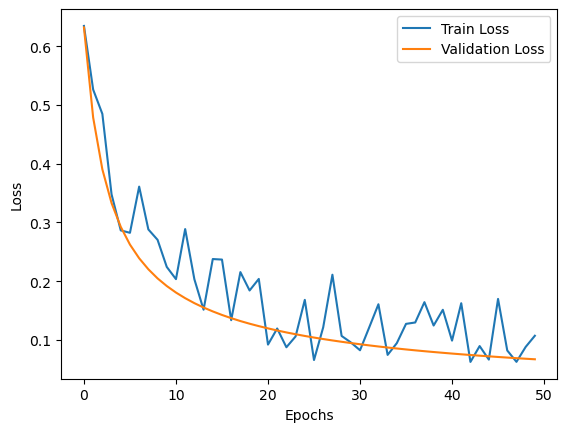

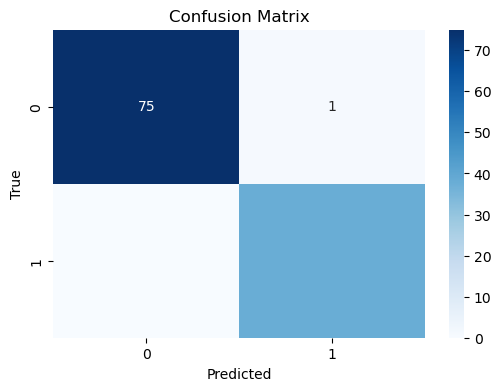

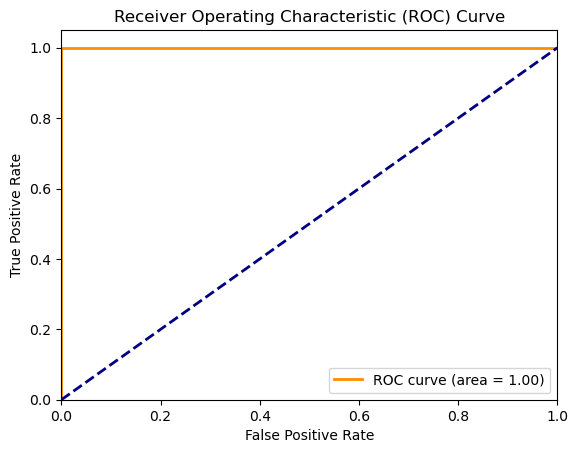

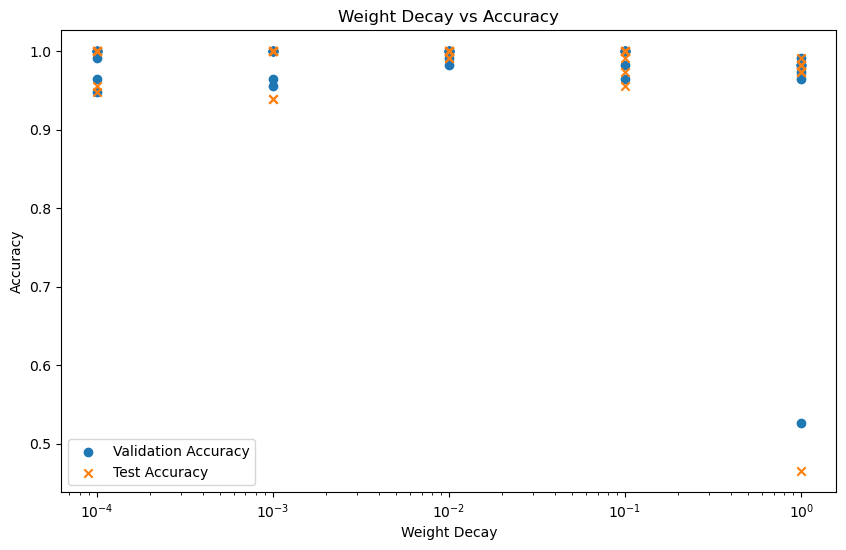

In [93]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, roc_curve, auc, accuracy_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import OneHotEncoder
from scipy.sparse import issparse
from ucimlrepo import fetch_ucirepo
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import itertools

class LogisticRegressionModel(nn.Module):
    def __init__(self, input_size, learning_rate, weight_decay, penalty):
        super(LogisticRegressionModel, self).__init__()
        self.linear = nn.Linear(input_size, 1)
        self.sigmoid = nn.Sigmoid()
        self.learning_rate = learning_rate
        self.weight_decay = weight_decay
        self.penalty = penalty

    def forward(self, x):
        out = self.linear(x)
        out = self.sigmoid(out)
        return out

class TabularDataset:
    def __init__(self, id=17):
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.epochs = 50
        self.id = id
        self.fetch_dataset()
        self.preprocess_data()
        self.split_data()
        self.standardize_data()
        self.convert_to_tensors()
        self.create_dataloaders()

    def fetch_dataset(self):
        self.dataset = fetch_ucirepo(id=self.id)

    def preprocess_data(self):
        X = self.dataset.data.features
        y = self.dataset.data.targets

        # Convert non-numeric features to numeric types
        label_encoder = LabelEncoder()
        y = label_encoder.fit_transform(y)

        # Combine features and targets into a DataFrame for easy handling
        df = pd.DataFrame(data=np.column_stack((X, y)))

        # Drop rows with missing values
        df.dropna(inplace=True)

        # Extract features and targets after handling missing values
        self.X = df.iloc[:, :-1].values
        self.y = df.iloc[:, -1].values

        # Identify numeric and categorical columns
        numeric_features = df.select_dtypes(include=['float64']).columns
        categorical_features = df.select_dtypes(include=['object']).columns

        # Apply transformations to numeric and categorical features
        numeric_transformer = StandardScaler()
        categorical_transformer = OneHotEncoder(handle_unknown='ignore')

        preprocessor = ColumnTransformer(
            transformers=[
                ('num', numeric_transformer, numeric_features),
                ('cat', categorical_transformer, categorical_features)
            ])

        # If input is sparse, use StandardScaler(with_mean=False)
        if issparse(self.X):
            preprocessor = make_pipeline(preprocessor, StandardScaler(with_mean=False))

        self.X = preprocessor.fit_transform(df)

    def split_data(self):
        self.X_train, self.X_temp, self.y_train, self.y_temp = train_test_split(
            self.X, self.y, test_size=0.4, random_state=42
        )
        self.X_val, self.X_test, self.y_val, self.y_test = train_test_split(
            self.X_temp, self.y_temp, test_size=0.5, random_state=42
        )

    def standardize_data(self):
        scaler = StandardScaler()
        self.X_train = scaler.fit_transform(self.X_train)
        self.X_val = scaler.transform(self.X_val)
        self.X_test = scaler.transform(self.X_test)

    def convert_to_tensors(self):
        self.X_train_tensor = torch.FloatTensor(self.X_train)
        self.y_train_tensor = torch.FloatTensor(self.y_train.reshape(-1, 1))
        self.X_val_tensor = torch.FloatTensor(self.X_val)
        self.y_val_tensor = torch.FloatTensor(self.y_val.reshape(-1, 1))
        self.X_test_tensor = torch.FloatTensor(self.X_test)
        self.y_test_tensor = torch.FloatTensor(self.y_test.reshape(-1, 1))

    def create_dataloaders(self):
        self.train_dataset = TensorDataset(self.X_train_tensor, self.y_train_tensor)
        self.val_dataset = TensorDataset(self.X_val_tensor, self.y_val_tensor)
        self.test_dataset = TensorDataset(self.X_test_tensor, self.y_test_tensor)

        self.train_loader = DataLoader(self.train_dataset, batch_size=32, shuffle=True)
        self.val_loader = DataLoader(self.val_dataset, batch_size=32, shuffle=False)
        self.test_loader = DataLoader(self.test_dataset, batch_size=32, shuffle=False)

class GridSearch:
    def __init__(self, model_class, hyperparameters):
        self.model_class = model_class
        self.hyperparameters = hyperparameters
        self.results = []

    def run_search(self, tabular_data):
        param_combinations = list(itertools.product(*self.hyperparameters.values()))

        for params in param_combinations:
            model = self.model_class(tabular_data.X_train.shape[1], *params).to(tabular_data.device)
            criterion = nn.BCELoss()
            optimizer = optim.SGD(model.parameters(), lr=params[0], weight_decay=params[1])

            train_losses = []
            val_losses = []

            for epoch in range(tabular_data.epochs):
                model.train()
                for inputs, labels in tabular_data.train_loader:
                    inputs, labels = inputs.to(tabular_data.device), labels.to(tabular_data.device)
                    optimizer.zero_grad()
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)
                    loss.backward()
                    optimizer.step()
                train_losses.append(loss.item())

                model.eval()
                with torch.no_grad():
                    val_loss = 0.0
                    for inputs, labels in tabular_data.val_loader:
                        inputs, labels = inputs.to(tabular_data.device), labels.to(tabular_data.device)
                        outputs = model(inputs)
                        loss = criterion(outputs, labels)
                        val_loss += loss.item()
                    val_losses.append(val_loss / len(tabular_data.val_loader))

            model.eval()
            with torch.no_grad():
                correct_test = 0
                total_test = 0
                for inputs, labels in tabular_data.test_loader:
                    inputs, labels = inputs.to(tabular_data.device), labels.to(tabular_data.device)
                    outputs = model(inputs)
                    predicted = (outputs > 0.5).float()
                    total_test += labels.size(0)
                    correct_test += (predicted == labels).sum().item()

                test_accuracy = correct_test / total_test

                correct_val = 0
                total_val = 0
                for inputs, labels in tabular_data.val_loader:
                    inputs, labels = inputs.to(tabular_data.device), labels.to(tabular_data.device)
                    outputs = model(inputs)
                    predicted = (outputs > 0.5).float()
                    total_val += labels.size(0)
                    correct_val += (predicted == labels).sum().item()

                val_accuracy = correct_val / total_val

                self.results.append({
                    'params': dict(zip(self.hyperparameters.keys(), params)),
                    'test_accuracy': test_accuracy,
                    'val_accuracy': val_accuracy,
                    'train_losses': train_losses,
                    'val_losses': val_losses
                })
    def plot_accuracy_vs_weight_decay(self):
        # Learning_rates=[]
        weight_decays=[]
        vals=[]
        tets=[]
        for param in self.results:
            weight_decays.append(param['params']['weight_decay'])
            vals.append(param['val_accuracy'])
            tets.append(param['test_accuracy'])
        plt.figure(figsize=(10, 6))
        plt.scatter(weight_decays, vals, label='Validation Accuracy', marker='o')
        plt.scatter(weight_decays, tets, label='Test Accuracy', marker='x')
        plt.xscale('log')  # Use a logarithmic scale for better visualization
        plt.xlabel('Weight Decay')
        plt.ylabel('Accuracy')
        plt.title('Weight Decay vs Accuracy')
        plt.legend()
        plt.show()
        # learning_rates = [params['learning_rate'] for params in self.results]
        # weight_decays = [params['weight_decay'] for params in self.results]
        # val_accuracies = [result['val_accuracy'] for result in self.results]
        # test_accuracies = [result['test_accuracy'] for result in self.results]


def plot_curves(train_losses, val_losses):
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

def plot_confusion_matrix(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=['0', '1'], yticklabels=['0', '1'])
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

def plot_roc_curve(y_true, y_scores):
    fpr, tpr, _ = roc_curve(y_true, y_scores)
    roc_auc = auc(fpr, tpr)

    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.show()


if __name__ == "__main__":
    hyperparameters = {
        'learning_rate': [0.001, 0.01, 0.1,1],
        'weight_decay': [1,0, 1e-4, 1e-3,1e-2,1e-1],
        'penalty': ['l1', 'l2']
    }

    tabular_data = TabularDataset()
    grid_search = GridSearch(LogisticRegressionModel, hyperparameters)
    grid_search.run_search(tabular_data)

    # Get the best result based on test accuracy
    best_result = max(grid_search.results, key=lambda x: x['test_accuracy'])
    best_params = best_result['params']
    print(best_params)
    # Train the model with the best parameters on the full training set
    best_model = LogisticRegressionModel(tabular_data.X_train.shape[1], *best_params.values()).to(tabular_data.device)
    criterion = nn.BCELoss()
    optimizer = optim.SGD(best_model.parameters(), lr=best_params['learning_rate'], weight_decay=best_params['weight_decay'])

    for epoch in range(tabular_data.epochs):
        best_model.train()
        for inputs, labels in tabular_data.train_loader:
            inputs, labels = inputs.to(tabular_data.device), labels.to(tabular_data.device)
            optimizer.zero_grad()
            outputs = best_model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

    # Evaluate on the test set
    best_model.eval()
    with torch.no_grad():
        y_true = []
        y_scores = []
        for inputs, labels in tabular_data.test_loader:
            inputs, labels = inputs.to(tabular_data.device), labels.to(tabular_data.device)
            outputs = best_model(inputs)
            predicted = (outputs > 0.5).float()
            y_true.extend(labels.cpu().numpy())
            y_scores.extend(outputs.cpu().numpy())

        test_accuracy = accuracy_score(y_true, (np.array(y_scores) > 0.5).astype(int))
        print(f'Test Accuracy: {test_accuracy * 100:.2f}%')

        plot_curves(best_result['train_losses'], best_result['val_losses'])
        plot_confusion_matrix(y_true, (np.array(y_scores) > 0.5).astype(int))
        plot_roc_curve(y_true, np.array(y_scores))
        # print(hyperparameters)
        # print("xx")
        # print(grid_search.results)
        grid_search.plot_accuracy_vs_weight_decay()


In [82]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, roc_curve, auc, accuracy_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import OneHotEncoder
from scipy.sparse import issparse
from ucimlrepo import fetch_ucirepo
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import itertools

class LogisticRegressionModel(nn.Module):
    def __init__(self, input_size, learning_rate, weight_decay, penalty, reg_strength):
        super(LogisticRegressionModel, self).__init__()
        self.linear = nn.Linear(input_size, 1)
        self.sigmoid = nn.Sigmoid()
        self.learning_rate = learning_rate
        self.weight_decay = weight_decay
        self.penalty = penalty
        self.reg_strength = reg_strength

    def forward(self, x):
        out = self.linear(x)
        out = self.sigmoid(out)
        return out

class TabularDataset:
    def __init__(self, id=17):
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.epochs = 50
        self.id = id
        self.fetch_dataset()
        self.preprocess_data()
        self.split_data()
        self.standardize_data()
        self.convert_to_tensors()
        self.create_dataloaders()

    def fetch_dataset(self):
        self.dataset = fetch_ucirepo(id=self.id)

    def preprocess_data(self):
        X = self.dataset.data.features
        y = self.dataset.data.targets

        # Convert non-numeric features to numeric types
        label_encoder = LabelEncoder()
        y = label_encoder.fit_transform(y)

        # Combine features and targets into a DataFrame for easy handling
        df = pd.DataFrame(data=np.column_stack((X, y)))

        # Drop rows with missing values
        df.dropna(inplace=True)

        # Extract features and targets after handling missing values
        self.X = df.iloc[:, :-1].values
        self.y = df.iloc[:, -1].values

        # Identify numeric and categorical columns
        numeric_features = df.select_dtypes(include=['float64']).columns
        categorical_features = df.select_dtypes(include=['object']).columns

        # Apply transformations to numeric and categorical features
        numeric_transformer = StandardScaler()
        categorical_transformer = OneHotEncoder(handle_unknown='ignore')

        preprocessor = ColumnTransformer(
            transformers=[
                ('num', numeric_transformer, numeric_features),
                ('cat', categorical_transformer, categorical_features)
            ])

        # If input is sparse, use StandardScaler(with_mean=False)
        if issparse(self.X):
            preprocessor = make_pipeline(preprocessor, StandardScaler(with_mean=False))

        self.X = preprocessor.fit_transform(df)

    def split_data(self):
        self.X_train, self.X_temp, self.y_train, self.y_temp = train_test_split(
            self.X, self.y, test_size=0.4, random_state=42
        )
        self.X_val, self.X_test, self.y_val, self.y_test = train_test_split(
            self.X_temp, self.y_temp, test_size=0.5, random_state=42
        )

    def standardize_data(self):
        scaler = StandardScaler()
        self.X_train = scaler.fit_transform(self.X_train)
        self.X_val = scaler.transform(self.X_val)
        self.X_test = scaler.transform(self.X_test)

    def convert_to_tensors(self):
        self.X_train_tensor = torch.FloatTensor(self.X_train)
        self.y_train_tensor = torch.FloatTensor(self.y_train.reshape(-1, 1))
        self.X_val_tensor = torch.FloatTensor(self.X_val)
        self.y_val_tensor = torch.FloatTensor(self.y_val.reshape(-1, 1))
        self.X_test_tensor = torch.FloatTensor(self.X_test)
        self.y_test_tensor = torch.FloatTensor(self.y_test.reshape(-1, 1))

    def create_dataloaders(self):
        self.train_dataset = TensorDataset(self.X_train_tensor, self.y_train_tensor)
        self.val_dataset = TensorDataset(self.X_val_tensor, self.y_val_tensor)
        self.test_dataset = TensorDataset(self.X_test_tensor, self.y_test_tensor)

        self.train_loader = DataLoader(self.train_dataset, batch_size=32, shuffle=True)
        self.val_loader = DataLoader(self.val_dataset, batch_size=32, shuffle=False)
        self.test_loader = DataLoader(self.test_dataset, batch_size=32, shuffle=False)

class GridSearch:
    def __init__(self, model_class, hyperparameters):
        self.model_class = model_class
        self.hyperparameters = hyperparameters
        self.results = []

    def run_search(self, tabular_data):
        param_combinations = list(itertools.product(*self.hyperparameters.values()))

        for params in param_combinations:
            model = self.model_class(tabular_data.X_train.shape[1], *params).to(tabular_data.device)
            criterion = nn.BCELoss()
            optimizer = optim.SGD(model.parameters(), lr=params[0], weight_decay=params[1])
            if 'reg_strength' in self.hyperparameters:
                optimizer.param_groups[0]['weight_decay'] = params[-1]

            train_losses = []
            val_losses = []

            for epoch in range(tabular_data.epochs):
                model.train()
                for inputs, labels in tabular_data.train_loader:
                    inputs, labels = inputs.to(tabular_data.device), labels.to(tabular_data.device)
                    optimizer.zero_grad()
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)
                    loss.backward()
                    optimizer.step()
                train_losses.append(loss.item())

                model.eval()
                with torch.no_grad():
                    val_loss = 0.0
                    for inputs, labels in tabular_data.val_loader:
                        inputs, labels = inputs.to(tabular_data.device), labels.to(tabular_data.device)
                        outputs = model(inputs)
                        loss = criterion(outputs, labels)
                        val_loss += loss.item()
                    val_losses.append(val_loss / len(tabular_data.val_loader))

            model.eval()
            with torch.no_grad():
                correct_test = 0
                total_test = 0
                for inputs, labels in tabular_data.test_loader:
                    inputs, labels = inputs.to(tabular_data.device), labels.to(tabular_data.device)
                    outputs = model(inputs)
                    predicted = (outputs > 0.5).float()
                    total_test += labels.size(0)
                    correct_test += (predicted == labels).sum().item()

                test_accuracy = correct_test / total_test

                correct_val = 0
                total_val = 0
                for inputs, labels in tabular_data.val_loader:
                    inputs, labels = inputs.to(tabular_data.device), labels.to(tabular_data.device)
                    outputs = model(inputs)
                    predicted = (outputs > 0.5).float()
                    total_val += labels.size(0)
                    correct_val += (predicted == labels).sum().item()

                val_accuracy = correct_val / total_val

                self.results.append({
                    'params': dict(zip(self.hyperparameters.keys(), params)),
                    'test_accuracy': test_accuracy,
                    'val_accuracy': val_accuracy,
                    'train_losses': train_losses,
                    'val_losses': val_losses
                })

def plot_curves(train_losses, val_losses):
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

def plot_confusion_matrix(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=['0', '1'], yticklabels=['0', '1'])
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

def plot_roc_curve(y_true, y_scores):
    fpr, tpr, _ = roc_curve(y_true, y_scores)
    roc_auc = auc(fpr, tpr)

    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.show()
    
def count_parameters(model):
    print(sum(p.numel() for p in model.parameters()))
    return sum(p.numel() for p in model.parameters())

def plot_metric_vs_complexity(results, tabular_data):
    complexity_values = [count_parameters(
        LogisticRegressionModel(tabular_data.X_train.shape[1], result['params']['learning_rate'], 
                                result['params']['weight_decay'], result['params']['penalty'])
                                .to(tabular_data.device))
                         for result in results]
    metric_values = [result['test_accuracy'] for result in results]

    plt.plot(complexity_values, metric_values, marker='o')
    plt.xlabel('Number of Parameters (Model Complexity)')
    plt.ylabel('Test Accuracy')
    plt.title('Test Accuracy vs. Model Complexity')
    plt.show()

    
if __name__ == "__main__":
    hyperparameters = {
        'learning_rate': [0.001, 0.01, 0.1,1],
        'weight_decay': [0, 1e-4, 1e-3,1e-2,1e-1],
        'penalty': ['l1', 'l2']
    }

    tabular_data = TabularDataset()
    grid_search = GridSearch(LogisticRegressionModel, hyperparameters)
    grid_search.run_search(tabular_data)

    # Get the best result based on test accuracy
    best_result = max(grid_search.results, key=lambda x: x['test_accuracy'])
    best_params = best_result['params']
    print(best_params)
    # Train the model with the best parameters on the full training set
    best_model = LogisticRegressionModel(tabular_data.X_train.shape[1], *best_params.values()).to(tabular_data.device)
    criterion = nn.BCELoss()
    optimizer = optim.SGD(best_model.parameters(), lr=best_params['learning_rate'], weight_decay=best_params['weight_decay'])

    for epoch in range(tabular_data.epochs):
        best_model.train()
        for inputs, labels in tabular_data.train_loader:
            inputs, labels = inputs.to(tabular_data.device), labels.to(tabular_data.device)
            optimizer.zero_grad()
            outputs = best_model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

    # Evaluate on the test set
    best_model.eval()
    with torch.no_grad():
        y_true = []
        y_scores = []
        for inputs, labels in tabular_data.test_loader:
            inputs, labels = inputs.to(tabular_data.device), labels.to(tabular_data.device)
            outputs = best_model(inputs)
            predicted = (outputs > 0.5).float()
            y_true.extend(labels.cpu().numpy())
            y_scores.extend(outputs.cpu().numpy())

        test_accuracy = accuracy_score(y_true, (np.array(y_scores) > 0.5).astype(int))
        print(f'Test Accuracy: {test_accuracy * 100:.2f}%')

        plot_curves(best_result['train_losses'], best_result['val_losses'])
        plot_confusion_matrix(y_true, (np.array(y_scores) > 0.5).astype(int))
        plot_roc_curve(y_true, np.array(y_scores))
        # print(hyperparameters)
        # print("xx")
        # print(grid_search.results)
        plot_metric_vs_complexity(grid_search.results, tabular_data)


/packages/envs/pytorch-gpu-2.0.1/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


TypeError: LogisticRegressionModel.__init__() missing 1 required positional argument: 'reg_strength'